# LoRa Data Analysis - Thompson Sampling


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Bandwidth: 125 kHz

End nodes:
- used a thompson sampling (TS) for communication parameters selection.

Access points:
- two access points were used to avoid a duty cycle depletion

Initial declaration

In [319]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib_inline as mpl_inl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

mpl_inl.backend_inline.set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable
subfolder = 'data/s3r1'
uplink_message_file = './' + subfolder + '/uplink_messages.csv'
algorithm = 'ts'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [320]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [321]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,...,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id,dev_id,application_id,battery
0,73565,QjVCQkJCAA==,12.25,-101,34892,t,2023-09-26 21:42:54.441,25623,866300000,10,...,-747508426,4/7,125000,2470,1,333333,iIiI,73535,NaN,NaN
1,73566,QjVCQkJCAA==,8.00,-99,34210,t,2023-09-26 21:42:59.483,5635,866300000,8,...,-747503021,4/7,125000,4118,1,333333,u7u7,73536,NaN,NaN
2,73567,QjVCQkJCAA==,12.25,-84,33933,t,2023-09-26 21:43:01.513,29158,866900000,8,...,-747501010,4/7,125000,2413,1,333333,3d3d,73537,NaN,NaN
3,73568,QjVCQkJCAA==,9.75,-59,33,f,2023-09-26 21:43:05.937,25625,866300000,10,...,-747496514,4/7,125000,2471,1,777777,iIiI,73538,NaN,NaN
4,73569,QjVCQkJCAA==,9.75,-95,33533,t,2023-09-26 21:43:05.938,25625,866300000,10,...,-747496517,4/7,125000,2471,1,333333,iIiI,73539,NaN,NaN


Let us have a look for different values to get an overview of overall values of different network parameters.

In [322]:
uplink_data.describe()

,id,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,bandwidth,msg_group_number,message_type_id,ap_id,dev_id,application_id,battery
count,2030.000000,2030.000000,2030.000000,2030.000000,2030.000000,2.030000e+03,2030.000000,2030.0,2.030000e+03,2030.0,2030.000000,2030.0,2030.000000,2030.000000,0.0,0.0
mean,74579.500000,9.255542,-85.625123,8731.080788,29971.102463,8.665364e+08,8.579310,0.0,-7.436171e+08,125000.0,2863.089163,1.0,531033.951724,74549.500000,NaN,NaN
std,586.154843,3.493428,16.650374,10838.323869,20449.839332,3.112456e+05,0.984536,0.0,3.069668e+06,0.0,687.737852,0.0,220919.391483,586.154843,NaN,NaN
min,73565.000000,-12.250000,-117.000000,1.000000,451.000000,8.661000e+08,7.000000,0.0,-7.475084e+08,125000.0,1886.000000,1.0,333333.000000,73535.000000,NaN,NaN
25%,74072.250000,8.250000,-102.000000,19.000000,10245.000000,8.663000e+08,8.000000,0.0,-7.469457e+08,125000.0,2404.000000,1.0,333333.000000,74042.250000,NaN,NaN
50%,74579.500000,10.000000,-83.000000,1542.000000,25945.000000,8.667000e+08,8.000000,0.0,-7.436055e+08,125000.0,2542.000000,1.0,333333.000000,74549.500000,NaN,NaN
75%,75086.750000,11.500000,-71.000000,16278.750000,46845.500000,8.669000e+08,10.000000,0.0,-7.401709e+08,125000.0,3300.750000,1.0,777777.000000,75056.750000,NaN,NaN
max,75594.000000,24.000000,-57.000000,35713.000000,65122.000000,8.669000e+08,10.000000,0.0,-7.393395e+08,125000.0,4320.000000,1.0,777777.000000,75564.000000,NaN,NaN


### Payload Length

In [323]:
uplink_data['payload_len'] = uplink_data.app_data.apply(len)
uplink_data.payload_len.describe()

count    2030.0
mean       12.0
std         0.0
min        12.0
25%        12.0
50%        12.0
75%        12.0
max        12.0
Name: payload_len, dtype: float64

In [324]:
payload_len = round(statistics.mean(uplink_data.payload_len), 2)
print(f'Mean value of payload length is {payload_len}.')

Mean value of payload length is 12.


### Spreading Factor

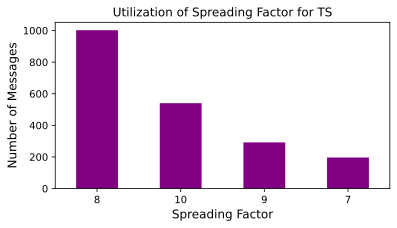

In [325]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='purple',figsize=(6,3))
hist.set_xlabel('Spreading Factor',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Spreading Factor for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-speading-factor.svg', dpi=300)
plt.show()

### Utilization of Frequency

Frequency is stored in Hz, so we need to convert it to MHz.

In [326]:
uplink_frequency = uplink_data.frequency / 1000000

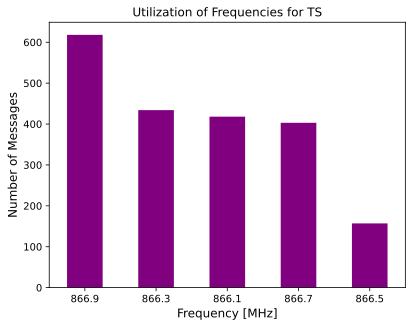

In [327]:
hist = uplink_frequency.value_counts().plot(kind='bar',rot=0,color='purple')
hist.set_xlabel('Frequency [MHz]',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

plt.title(f'Utilization of Frequencies for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-frequencies.svg', dpi=300)
plt.show()

### Unique Uplink Messages

In [328]:
unique_messages = uplink_data[uplink_data.is_primary=="t"]
print(f'Uplink messages received during experiment: {len(unique_messages)}')

Uplink messages received during experiment: 1343


### Received Signal Strength Indicator

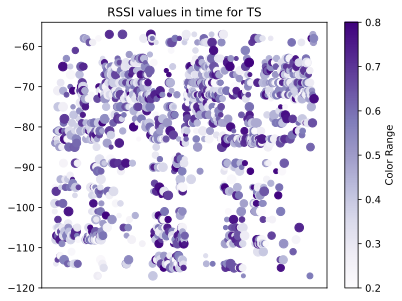

In [329]:
x = unique_messages.id
y = unique_messages.rssi
hist.set_xlabel('Time', fontsize=12)
#hist.set_ylabel('Number of Messages', fontsize=12)

# size and color:
sizes = np.random.uniform(15, 80, len(x))

# Define the colormap 'Purples' which is a gradient of purple
cmap = plt.get_cmap('Purples')

# Define vmin and vmax values to control the gradient
vmin = 0.2
vmax = 0.8

# Generate random values within the range [vmin, vmax]
normalized_values = (np.random.rand(len(x)) * (vmax - vmin)) + vmin

fig, ax = plt.subplots()
sc = ax.scatter(x, y, s=sizes, c=normalized_values, cmap=cmap, vmin=vmin, vmax=vmax)

# Add colorbar for reference
cbar = plt.colorbar(sc)
cbar.set_label('Color Range')

ax.set_xticks([])

plt.title(f'RSSI values in time for {algorithm.upper()}')
plt.savefig(f'./{subfolder}/{algorithm}-rssi.svg', dpi=300)
plt.show()

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [330]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 10.


In [331]:
uplink_data.node_id.describe()

count     2030
unique      10
top       u7u7
freq       321
Name: node_id, dtype: object

In [332]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 10
Total number of connected access points: 2


### Ratio of Message Transmission Attempts to Successful Message Deliveries (MTAMD)

Evaluation of MTAMD for end nodes.

In [333]:
end_nodes = unique_messages.groupby('node_id')

seq_tolerance = 15
first_seq = 0
last_seq = 0
prev_seq = 0
prev_node_id = ""
msg_count = 0
msg_delivered = 0
total_msg_count = 0

for name,group in end_nodes:
    #print('ID:' + str(name))
    #print(group['seq'])

    for seq in group['seq']:
        #print(name, seq)
        if (abs(prev_seq - seq) > seq_tolerance):
            total_msg_count += prev_seq - first_seq
            #print(prev_node_id, prev_seq, seq, first_seq, prev_seq - first_seq, msg_count)
            msg_delivered += msg_count
            first_seq = seq
            msg_count = 0
        if prev_seq != seq:
            msg_count += 1
        prev_seq = seq
        prev_node_id = name
    if total_msg_count != 0:
        pdr = min(round(msg_delivered / total_msg_count * 100, 2), 100.0)
    else:
        pdr = 0.0
    print(f'{name} reached MTAMD {pdr}%')
    first_seq = 0
    last_seq = 0
    prev_seq = 0
    msg_count = 0
    msg_delivered = 0
    total_msg_count = 0


3d3d reached MTAMD 61.86%
7u7u reached MTAMD 75.68%
VVVV reached MTAMD 73.08%
ZmZm reached MTAMD 56.59%
d3d3 reached MTAMD 67.74%
iIiI reached MTAMD 63.6%
mZmZ reached MTAMD 64.46%
qqqq reached MTAMD 66.37%
u7u7 reached MTAMD 62.59%
zMzM reached MTAMD 64.98%


### Number of unique message per bandit node

In [334]:
unique_message_counts = unique_messages['node_id'].value_counts().reset_index()
unique_message_counts.columns = ['node_id', 'unique_messages_count']
print(unique_message_counts)

  node_id  unique_messages_count
0    u7u7                    203
1    iIiI                    197
2    mZmZ                    191
3    qqqq                    185
4    zMzM                    174
5    ZmZm                    151
6    3d3d                    140
7    7u7u                     41
8    VVVV                     31
9    d3d3                     30


The End.